In [3]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
import string
import random
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import pandas as pd
import numpy as np

# Process Data

In [5]:
def parse(path):
    """
    Reads the file line by line and uses eval() to parse
    Python-dictionary-style lines (single quotes, u'' strings).
    """
    g = gzip.open(path, 'rb')
    for l in g:
        # yield eval(l) handles both {'a':1} and {u'a':1}
        yield eval(l)

print("Loading Bundle Data...")
bundles = []
for line in parse('/content/bundle_data.json.gz'):
    bundles.append(line)
df_bundles = pd.DataFrame(bundles)
print(f"Successfully Loaded {len(df_bundles)} bundles.")


print("Loading Game Metadata...")
games_metadata = []
for line in parse('/content/steam_games.json.gz'):
    if 'id' in line:
        games_metadata.append(line)
df_meta = pd.DataFrame(games_metadata)
print(f"Successfully Loaded {len(df_meta)} game metadata.")


print("Loading User Reviews...")
user_reviews = []
count = 0
for line in parse('/content/australian_user_reviews.json.gz'):
    user_reviews.append(line)
    count += 1
    if count > 150000: break

df_reviews = pd.DataFrame(user_reviews)
# Flatten reviews (One row per review, not per user)
review_data = []
for idx, row in df_reviews.iterrows():
    u_id = row['user_id']
    for r in row['reviews']:
        review_data.append({
            'user_id': u_id,
            'item_id': r['item_id'],
            'recommend': r['recommend'],
            'review_text': r['review']
        })
df_flat_reviews = pd.DataFrame(review_data)
print(f"Loaded {len(df_flat_reviews)} individual reviews.")


print("Loading User Items (Ownership & Playtime)...")
data_items = []
limit = 150000  #Increase this if you have more RAM.
count = 0

for line in parse('/content/australian_users_items.json.gz'):
    data_items.append(line)
    count += 1
    if count > limit:
        break
df_items = pd.DataFrame(data_items)
print(f"Successfully Loaded {len(df_items)} users.")

Loading Bundle Data...
Successfully Loaded 615 bundles.
Loading Game Metadata...
Successfully Loaded 32133 game metadata.
Loading User Reviews...
Loaded 59305 individual reviews.
Loading User Items (Ownership & Playtime)...
Successfully Loaded 88310 users.


In [6]:
print("Preparing Interaction Matrix")
interactions = []

for index, row in df_items.iterrows():
    u_id = row['user_id']
    for i in row['items']:
        # FILTER: Only keep if playtime > 0
        if i['playtime_forever'] > 0:
            interactions.append([u_id, i['item_id'], 1])

df_interactions = pd.DataFrame(interactions, columns=['user_id', 'item_id', 'interaction'])

print(f"Processed {len(df_interactions)} valid interactions.")
print(f"Unique Games Played: {df_interactions['item_id'].nunique()}")
print("Interaction df complete. Ready for Modeling.")

Preparing Interaction Matrix
Processed 3285246 valid interactions.
Unique Games Played: 10050
Interaction df complete. Ready for Modeling.


## Bundles EDA

In [7]:
df_bundles.head()

,bundle_final_price,bundle_url,bundle_price,bundle_name,bundle_id,items,bundle_discount
0,$66.46,http://store.steampowered.com/bundle/450/?utm_...,$73.86,Dharker Studio 2015 Complete,450,"[{'genre': 'Adventure, Indie, RPG', 'item_id':...",10%
1,$20.15,http://store.steampowered.com/bundle/1473/?utm...,$25.87,"Naruto Shippuden Uncut Season 4, Vol. 3",1473,"[{'genre': '', 'item_id': '528360', 'discounte...",22%
2,$20.15,http://store.steampowered.com/bundle/1474/?utm...,$25.87,"Naruto Shippuden Uncut Season 4, Vol. 4",1474,"[{'genre': '', 'item_id': '528380', 'discounte...",22%
3,$15.17,http://store.steampowered.com/bundle/1437/?utm...,$25.35,Pixel Puzzles Ultimate: Starter Kit,1437,"[{'genre': 'Casual, Free to Play, Indie, Simul...",40%
4,$20.15,http://store.steampowered.com/bundle/1466/?utm...,$25.87,"Naruto Shippuden Uncut Season 4, Vol. 1",1466,"[{'genre': '', 'item_id': '527830', 'discounte...",22%


In [8]:
df_bundles['bundle_final_price'] = df_bundles['bundle_final_price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False)
df_bundles['bundle_price'] = df_bundles['bundle_price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False)

df_bundles['bundle_final_price'] = pd.to_numeric(df_bundles['bundle_final_price'], errors='coerce')
df_bundles['bundle_price'] = pd.to_numeric(df_bundles['bundle_price'], errors='coerce')

In [9]:
df_bundles.head()

,bundle_final_price,bundle_url,bundle_price,bundle_name,bundle_id,items,bundle_discount
0,66.46,http://store.steampowered.com/bundle/450/?utm_...,73.86,Dharker Studio 2015 Complete,450,"[{'genre': 'Adventure, Indie, RPG', 'item_id':...",10%
1,20.15,http://store.steampowered.com/bundle/1473/?utm...,25.87,"Naruto Shippuden Uncut Season 4, Vol. 3",1473,"[{'genre': '', 'item_id': '528360', 'discounte...",22%
2,20.15,http://store.steampowered.com/bundle/1474/?utm...,25.87,"Naruto Shippuden Uncut Season 4, Vol. 4",1474,"[{'genre': '', 'item_id': '528380', 'discounte...",22%
3,15.17,http://store.steampowered.com/bundle/1437/?utm...,25.35,Pixel Puzzles Ultimate: Starter Kit,1437,"[{'genre': 'Casual, Free to Play, Indie, Simul...",40%
4,20.15,http://store.steampowered.com/bundle/1466/?utm...,25.87,"Naruto Shippuden Uncut Season 4, Vol. 1",1466,"[{'genre': '', 'item_id': '527830', 'discounte...",22%


In [10]:
df_bundles.iloc[87]['items']

[{'genre': 'Adventure',
  'item_id': '443330',
  'discounted_price': '$12.99',
  'item_url': 'http://store.steampowered.com/app/443330',
  'item_name': 'Malus Code'},
 {'genre': 'Adventure',
  'item_id': '514320',
  'discounted_price': '$2.99',
  'item_url': 'http://store.steampowered.com/app/514320',
  'item_name': 'Malus Code - Original Soundtrack'}]

In [12]:
bundle_game_counts = df_bundles['items'].apply(len)
bundle_game_counts.name = 'item_counts'

df_bundles['items_count'] = bundle_game_counts

In [13]:
df_bundles.describe()

,bundle_final_price,bundle_price,items_count
count,615.000000,615.000000,615.000000
mean,34.546667,47.017805,5.731707
std,53.004913,79.007359,8.013500
min,0.840000,1.980000,2.000000
25%,9.455000,12.970000,2.000000
50%,19.970000,24.980000,3.000000
75%,35.985000,47.625000,5.000000
max,575.840000,999.980000,89.000000


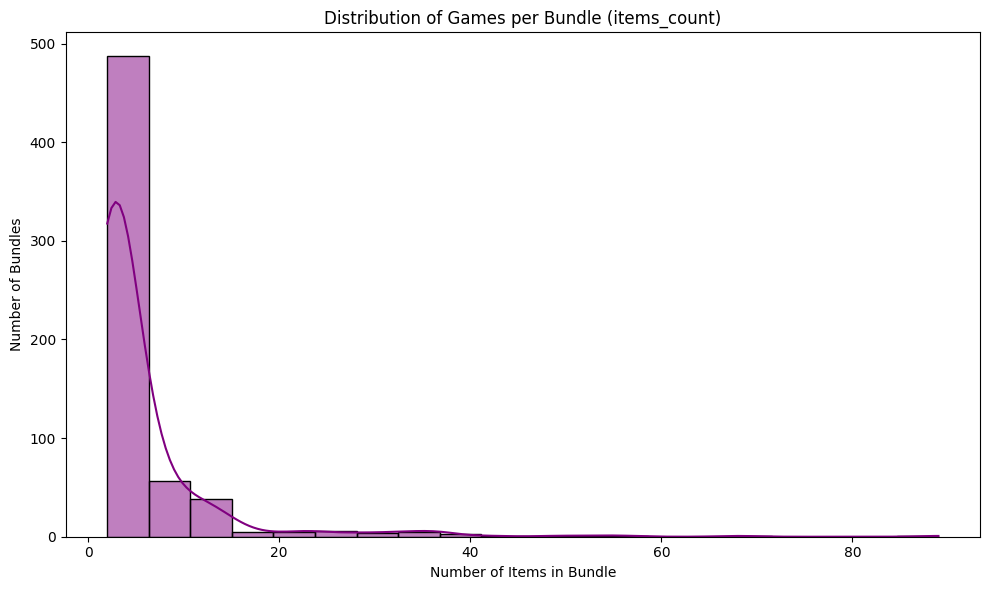

In [14]:
plt.figure(figsize=(10, 6))
# Using a log scale on the y-axis helps visualize the distribution of less frequent bundles
sns.histplot(df_bundles['items_count'], bins=20, kde=True, color='purple', log_scale=(False, False))
plt.title('Distribution of Games per Bundle (items_count)')
plt.xlabel('Number of Items in Bundle')
plt.ylabel('Number of Bundles')
plt.tight_layout()
plt.show()

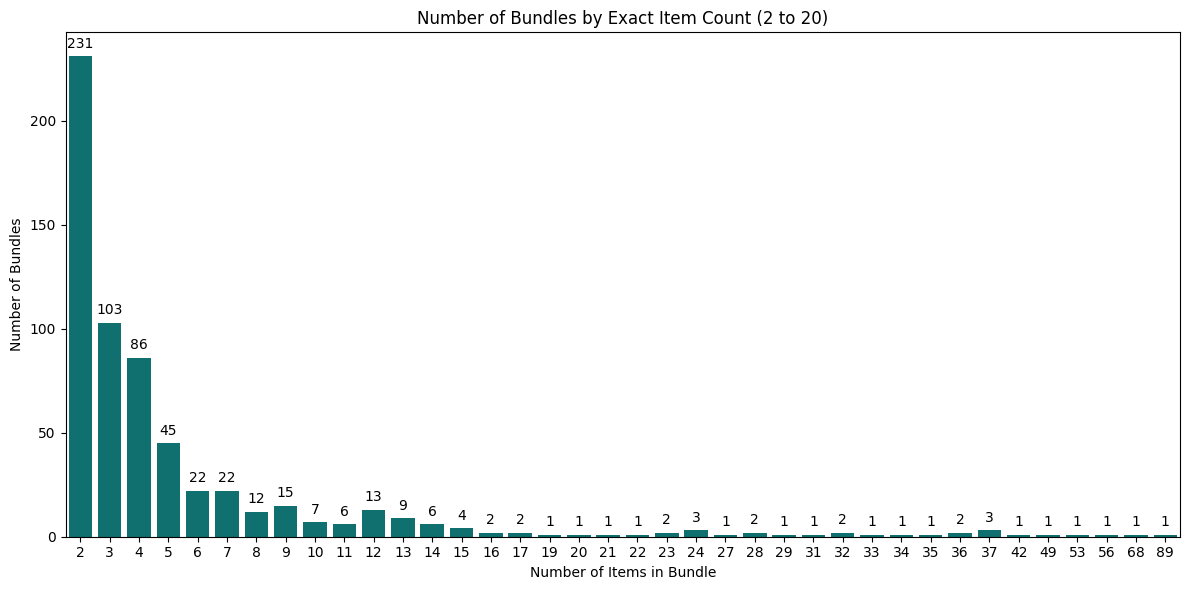

In [19]:
df_filtered = df_bundles[(df_bundles['items_count'] >= 2) & (df_bundles['items_count'] <= 89)].copy()

bundle_counts = df_filtered['items_count'].value_counts().sort_index().reset_index()
bundle_counts.columns = ['items_count', 'bundle_count']

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='items_count', y='bundle_count', data=bundle_counts, color='teal')

plt.title('Number of Bundles by Exact Item Count (2 to 20)')
plt.xlabel('Number of Items in Bundle')
plt.ylabel('Number of Bundles')


for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.tight_layout()
plt.show()

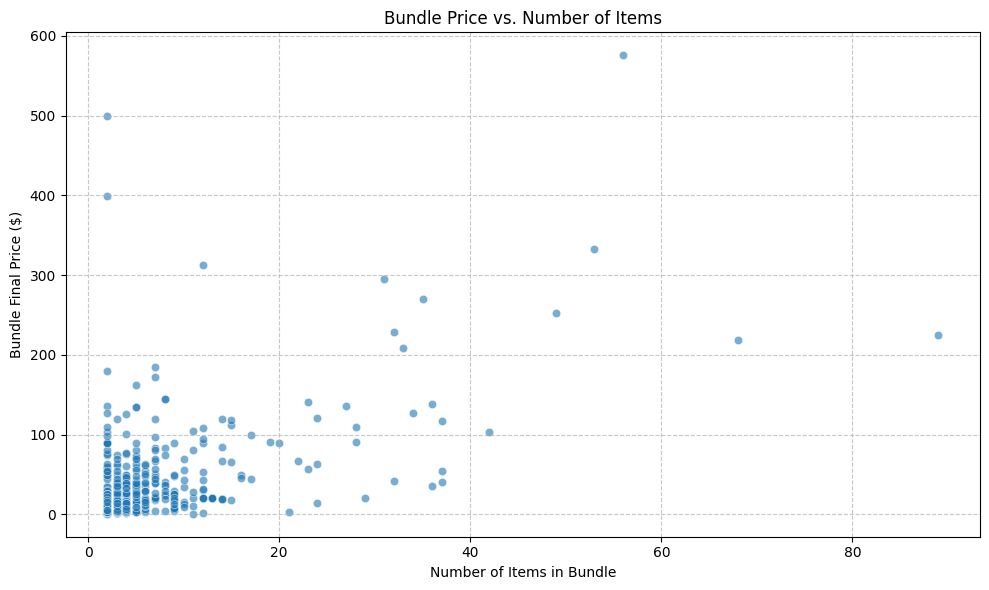

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='items_count', y='bundle_final_price', data=df_bundles, alpha=0.6)
plt.title('Bundle Price vs. Number of Items')
plt.xlabel('Number of Items in Bundle')
plt.ylabel('Bundle Final Price ($)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

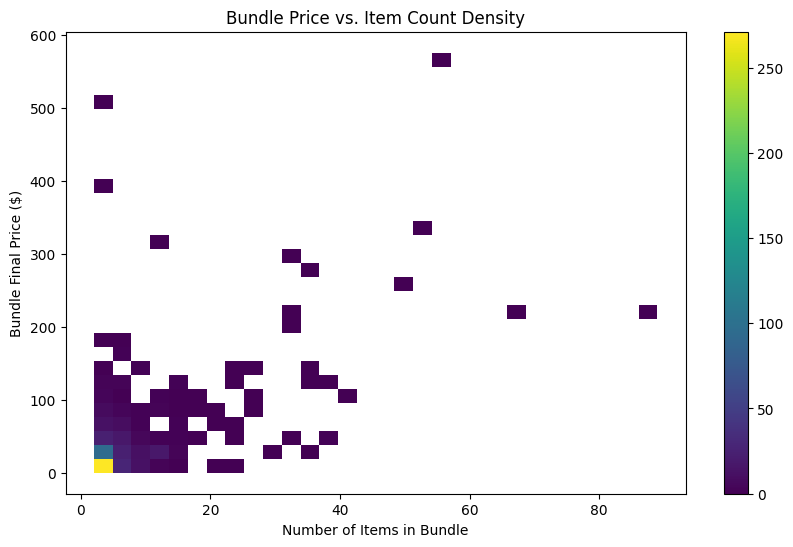

In [22]:
plt.figure(figsize=(10, 6))

sns.histplot(x='items_count',
             y='bundle_final_price',
             data=df_bundles,
             bins=30,  # Number of bins in both x and y directions
             cbar=True, # Display the color bar legend
             cmap='viridis')

plt.title('Bundle Price vs. Item Count Density')
plt.xlabel('Number of Items in Bundle')
plt.ylabel('Bundle Final Price ($)')
plt.show()

## Games Metadata EDA

In [23]:
df_meta

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32128,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.49,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,773640,"Nikita ""Ghost_RUS""",NaN,NaN
32129,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",4.24,http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,733530,Sacada,NaN,NaN
32130,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",1.39,http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich,NaN,NaN
32131,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",NaN,http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870,"xropi,stev3ns",1 user reviews,NaN


In [24]:
# relevant columns
df_meta = df_meta[['id', 'app_name', 'genres', 'price', 'tags']]
df_meta = df_meta.rename(columns={'id': 'item_id'})

def clean_price(x):
    if isinstance(x, str):
        if 'free' in x.lower(): return 0.0
        try: return float(x)
        except: return np.nan # weird strings
    return x

df_meta['price'] = df_meta['price'].apply(clean_price)
df_meta['price'] = df_meta['price'].fillna(0.0)
df_meta

,item_id,app_name,genres,price,tags
0,761140,Lost Summoner Kitty,"[Action, Casual, Indie, Simulation, Strategy]",4.99,"[Strategy, Action, Indie, Casual, Simulation]"
1,643980,Ironbound,"[Free to Play, Indie, RPG, Strategy]",0.00,"[Free to Play, Strategy, Indie, RPG, Card Game..."
2,670290,Real Pool 3D - Poolians,"[Casual, Free to Play, Indie, Simulation, Sports]",0.00,"[Free to Play, Simulation, Sports, Casual, Ind..."
3,767400,弹炸人2222,"[Action, Adventure, Casual]",0.99,"[Action, Adventure, Casual]"
4,773570,Log Challenge,NaN,2.99,"[Action, Indie, Casual, Sports]"
...,...,...,...,...,...
32128,773640,Colony On Mars,"[Casual, Indie, Simulation, Strategy]",1.99,"[Strategy, Indie, Casual, Simulation]"
32129,733530,LOGistICAL: South Africa,"[Casual, Indie, Strategy]",4.99,"[Strategy, Indie, Casual]"
32130,610660,Russian Roads,"[Indie, Racing, Simulation]",1.99,"[Indie, Simulation, Racing]"
32131,658870,EXIT 2 - Directions,"[Casual, Indie]",4.99,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe..."


In [40]:
df_meta.iloc[12087]

,12087
item_id,719000
app_name,Strata Spaces VR – Professional Edition Upgrade
genres,"[Animation &amp; Modeling, Design &amp; Illust..."
price,995.0
tags,"[Design & Illustration, Animation & Modeling]"


In [38]:
df_meta['price'].sort_values()

,price
19756,0.00
8708,0.00
28314,0.00
28313,0.00
16616,0.00
...,...
14303,499.99
17793,499.99
23593,599.00
2391,771.71


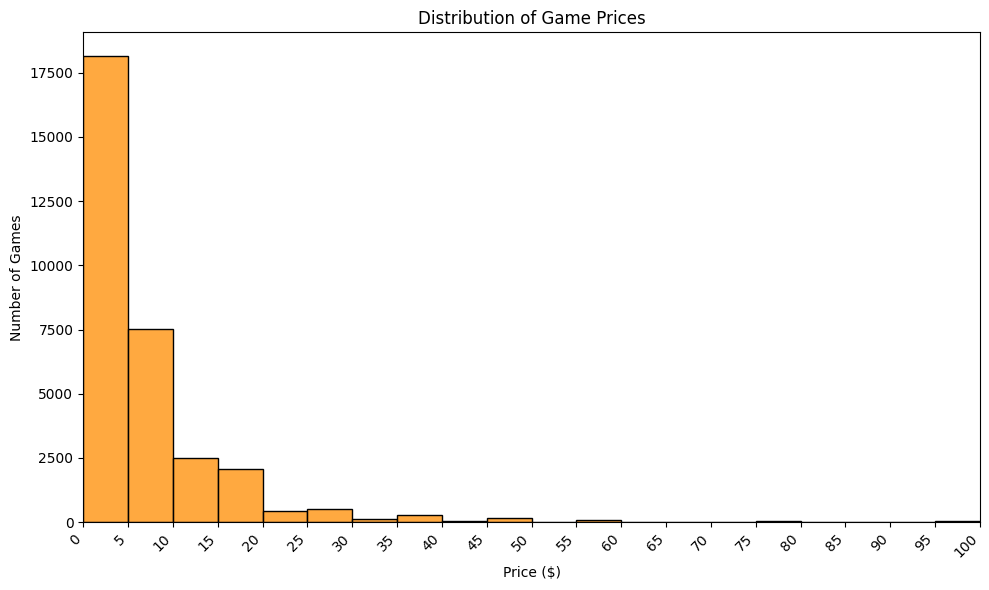

In [41]:
# Define the user's cleaning function (ensure this runs before plotting)
def clean_price(x):
    if isinstance(x, str):
        if 'free' in x.lower(): return 0.0
        try: return float(x)
        except: return np.nan
    return x

# Apply cleaning and filling (assuming you ran the original code successfully)
df_meta['price'] = df_meta['price'].apply(clean_price)
df_meta['price'] = df_meta['price'].fillna(0.0)

# Ensure the column is numeric for plotting
df_meta['price'] = pd.to_numeric(df_meta['price'], errors='coerce')

# Determine bin limits (interval 5)
max_price = 100#df_meta['price'].max()
# Creates bins starting at 0, interval 5, ending slightly past max price
bins = np.arange(0, max_price + 5, 5)

plt.figure(figsize=(10, 6))
sns.histplot(df_meta['price'], bins=bins, kde=False, color='darkorange')

plt.title('Distribution of Game Prices')
plt.xlabel('Price ($)')
plt.ylabel('Number of Games')

# Set x-ticks to align exactly with the bin boundaries
plt.xticks(bins, rotation=45, ha='right')
plt.xlim(0, bins[-1])
plt.tight_layout()
plt.show()

/tmp/ipython-input-987878995.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='magma')


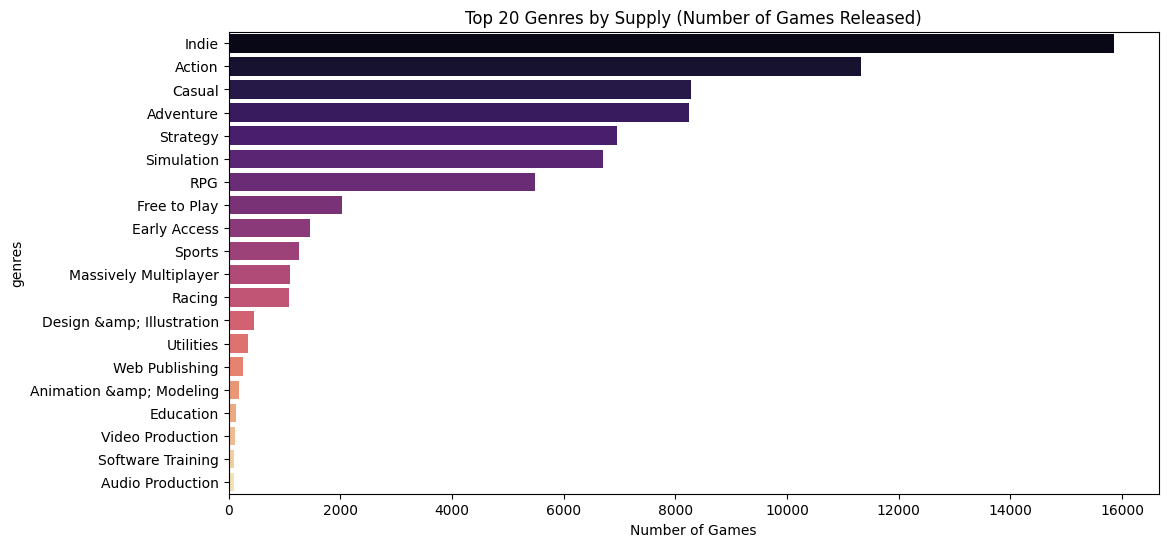

In [27]:
# Genre Analysis - 'explode' the genres column (because games have multiple genres)
df_exploded = df_meta.explode('genres')

# Count how many games exist per genre
plt.figure(figsize=(12, 6))
genre_counts = df_exploded['genres'].value_counts().head(20)
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='magma')
plt.title('Top 20 Genres by Supply (Number of Games Released)')
plt.xlabel('Number of Games')
plt.show()

In [28]:
print(df_exploded['genres'].value_counts().head(20))

genres
Indie                        15858
Action                       11320
Casual                        8282
Adventure                     8242
Strategy                      6957
Simulation                    6699
RPG                           5479
Free to Play                  2031
Early Access                  1462
Sports                        1257
Massively Multiplayer         1108
Racing                        1083
Design &amp; Illustration      460
Utilities                      340
Web Publishing                 268
Animation &amp; Modeling       183
Education                      125
Video Production               116
Software Training              105
Audio Production                93
Name: count, dtype: int64


* Interpretation: The platform is flooded with Indie titles.

* Memo for Modeling:

  * Discovery Problem: Because there are so many Indie games, users suffer from "Choice Paralysis." They can't find good Indie games among the 15,000 options. This makes a Recommender System highly valuable for this specific genre.

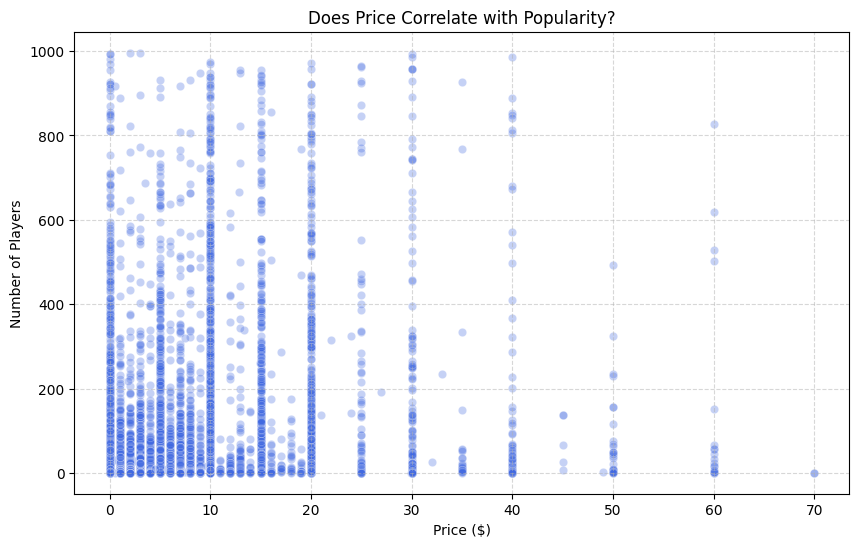

Correlation between Price and Popularity: 0.05904873687809753


In [29]:
# Price vs. Playtime
# Merge Metadata with our Interaction Data
# aggregate interactions to get 'Total Playtime' per game
game_playtime_agg = df_interactions.groupby('item_id')['interaction'].count().reset_index()
game_playtime_agg.columns = ['item_id', 'player_count']

# Merge with metadata
df_merged = pd.merge(game_playtime_agg, df_meta, on='item_id', how='inner')

# Plot Price vs Popularity
plt.figure(figsize=(10, 6))
# Filter outliers for visualization (Price < 60, Players < 5000)
subset = df_merged[(df_merged['price'] < 70) & (df_merged['player_count'] < 1000)]
sns.scatterplot(data=subset, x='price', y='player_count', alpha=0.3, color='royalblue')
plt.title('Does Price Correlate with Popularity?')
plt.xlabel('Price ($)')
plt.ylabel('Number of Players')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print("Correlation between Price and Popularity:", df_merged['price'].corr(df_merged['player_count']))

* Interpretation: A game being expensive ($60) does not make it more popular. A game being free doesn't guarantee success (plenty of free games fail).

* Memo for Modeling:

  * Feature Selection: we should consider dropping price as a feature. It has no predictive power regarding whether a user will play a game.

## User Reviews EDA

In [30]:
df_reviews.iloc[0]['reviews']

[{'funny': '',
  'posted': 'Posted November 5, 2011.',
  'last_edited': '',
  'item_id': '1250',
  'helpful': 'No ratings yet',
  'recommend': True,
  'review': 'Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.'},
 {'funny': '',
  'posted': 'Posted July 15, 2011.',
  'last_edited': '',
  'item_id': '22200',
  'helpful': 'No ratings yet',
  'recommend': True,
  'review': "It's unique and worth a playthrough."},
 {'funny': '',
  'posted': 'Posted April 21, 2011.',
  'last_edited': '',
  'item_id': '43110',
  'helpful': 'No ratings yet',
  'recommend': True,
  'review': 'Great atmosphere. The gunplay can be a bit chunky at times but at the end of the day this game is definitely worth it and I hope they do a sequel...so buy the game so I get a sequel!'}]

In [31]:
df_flat_reviews.head(10)

,user_id,item_id,recommend,review_text
0,76561197970982479,1250,True,Simple yet with great replayability. In my opi...
1,76561197970982479,22200,True,It's unique and worth a playthrough.
2,76561197970982479,43110,True,Great atmosphere. The gunplay can be a bit chu...
3,js41637,251610,True,I know what you think when you see this title ...
4,js41637,227300,True,For a simple (it's actually not all that simpl...
5,js41637,239030,True,Very fun little game to play when your bored o...
6,evcentric,248820,True,A suitably punishing roguelike platformer. Wi...
7,evcentric,370360,True,"""Run for fun? What the hell kind of fun is that?"""
8,evcentric,237930,True,"Elegant integration of gameplay, story, world ..."
9,evcentric,263360,True,"Random drops and random quests, with stat poin..."


In [42]:
print(df_flat_reviews['recommend'].value_counts())
df_flat_reviews.query('recommend == False').head()

recommend
True     52473
False     6832
Name: count, dtype: int64


,user_id,item_id,recommend,review_text
48,76561198043472122,33440,False,This Game Doesn't Work
62,76561198066046412,359320,False,"♥♥♥♥♥ charged me 80 now its 15 dollars, got bo..."
68,76561198070565427,570,False,"w,"
84,boydeer,383080,False,เกมเเดกเงินดีๆนี้เอง
122,sandwiches1,417860,False,Emily is a thot


In [33]:
df_flat_reviews['item_id'].nunique()

3682

In [35]:
import random
# Group by game (item_id) and check the number of True and False recommendations
game_recommendation_counts = df_flat_reviews.groupby('item_id')['recommend'].value_counts().unstack(fill_value=0)

# Filter for games that have at least one True AND at least one False review
controversial_games = game_recommendation_counts[
    (game_recommendation_counts[True] >= 1) &
    (game_recommendation_counts[False] >= 1)
]

# Get a list of the item_ids for these games
controversial_ids = controversial_games.index.tolist()

# Select 5 random controversial games
sample_game_ids = random.sample(controversial_ids, 5)

print("--- Sample Reviews for 5 Controversial Games ---")

# Iterate through the 5 sampled games
for game_id in sample_game_ids:
    print(f"\n================ GAME ID: {game_id} ================")

    # Filter all reviews for the current game
    game_reviews = df_flat_reviews.query('item_id == @game_id')

    # 1. Get Recommendation Counts (Numerical Glimpse)
    counts = game_reviews['recommend'].value_counts()
    true_count = counts.get(True, 0)
    false_count = counts.get(False, 0)

    print(f"Total Reviews: {true_count + false_count}")
    print(f"Recommended (True): {true_count}")
    print(f"Not Recommended (False): {false_count}")
    print("-----------------------------------------")

    # 2. Sample Positive Reviews (Text Glimpse)
    positive_reviews = game_reviews.query('recommend == True')['review_text'].sample(min(3, true_count), random_state=42)
    print("Positive Review Examples (Random 3):")
    for i, review in enumerate(positive_reviews):
        print(f"  {i+1}. {review[:100].replace('\n', ' ')}...") # Show first 100 chars

    # 3. Sample Negative Reviews (Text Glimpse)
    negative_reviews = game_reviews.query('recommend == False')['review_text'].sample(min(3, false_count), random_state=42)
    print("\nNegative Review Examples (Random 3):")
    for i, review in enumerate(negative_reviews):
        print(f"  {i+1}. {review[:100].replace('\n', ' ')}...") # Show first 100 chars

--- Sample Reviews for 5 Controversial Games ---

================ GAME ID: 502550 ================
Total Reviews: 2
Recommended (True): 1
Not Recommended (False): 1
-----------------------------------------
Positive Review Examples (Random 3):
  1. muito bom worms.io + armas...

Negative Review Examples (Random 3):
  1. pure ♥♥♥♥whenever I aim at an ememy, the gun just aims in the other directionlags like hellalso it i...

================ GAME ID: 241320 ================
Total Reviews: 3
Recommended (True): 2
Not Recommended (False): 1
-----------------------------------------
Positive Review Examples (Random 3):
  1. it's a fun game and all, but i'm so done with fishbuns.SO. DONE....
  2. yea...

Negative Review Examples (Random 3):
  1. While yes i enjoyed playing this game i found that the lack of a simple save button was annoying, an...

================ GAME ID: 431240 ================
Total Reviews: 20
Recommended (True): 18
Not Recommended (False): 2
--------------------------

In [43]:
# 1. Merge the reviews with the metadata on 'item_id'
# We only need the 'recommend' status from reviews and 'price' from metadata.
df_merged = df_flat_reviews.merge(
    df_meta[['item_id', 'price']],
    on='item_id',
    how='left'
)

# 2. Filter the merged DataFrame to select only free games (Price = 0.0)
df_free_games_reviews = df_merged.query('price == 0.0')

# 3. Calculate the distribution of recommendations for free games
print("--- Review Distribution for FREE Games ($0.00 Price) ---")
print(df_free_games_reviews['recommend'].value_counts())

# 4. Optional: Calculate the percentage of negative reviews for free games
total_reviews = df_free_games_reviews['recommend'].count()
false_reviews = df_free_games_reviews.query('recommend == False')['recommend'].count()
if total_reviews > 0:
    print(f"\nTotal reviews for free games: {total_reviews}")
    print(f"Percentage of negative reviews: {false_reviews / total_reviews:.2%}")

--- Review Distribution for FREE Games ($0.00 Price) ---
recommend
True     13783
False     1806
Name: count, dtype: int64

Total reviews for free games: 15589
Percentage of negative reviews: 11.59%


/tmp/ipython-input-1494187659.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='recommend', y='playtime_hours', data=plot_data, palette='Set2')


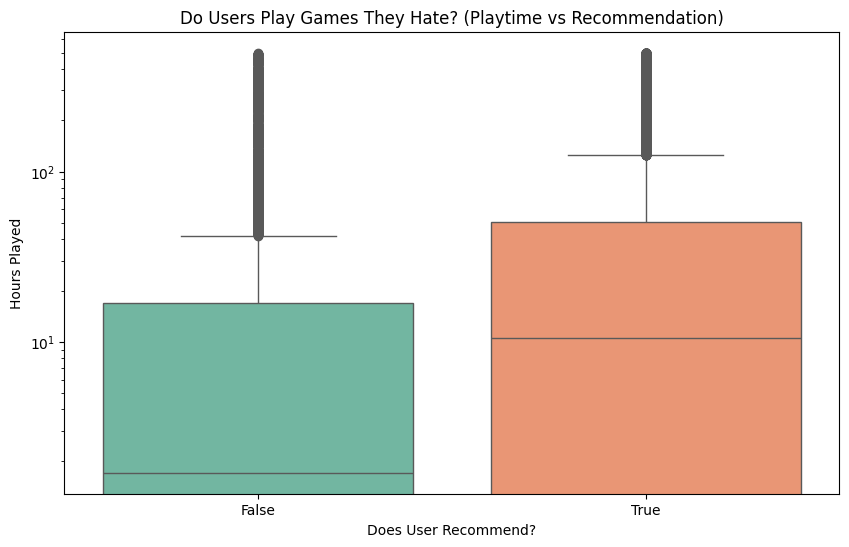

Median Playtime for Recommended Games: 13.30 hours
Median Playtime for NOT Recommended Games: 2.13 hours


In [ ]:
# --- 6. EDA: Implicit vs Explicit Signal ---
# We want to see: Do people play games they "Downvote"?
# We need to merge Playtime (from df_interactions) into this review data.

# First, recover playtime map from df_items (it's faster than merging huge dfs)
# Create a dictionary: (user_id, item_id) -> playtime
playtime_map = {}
for index, row in df_items.iterrows():
    u_id = row['user_id']
    for item in row['items']:
        playtime_map[(u_id, item['item_id'])] = item['playtime_forever']

# Map playtime to reviews
df_flat_reviews['playtime'] = df_flat_reviews.apply(
    lambda x: playtime_map.get((x['user_id'], x['item_id']), 0), axis=1
)

# Convert to Hours
df_flat_reviews['playtime_hours'] = df_flat_reviews['playtime'] / 60

# --- Visualization: Playtime of Recommended vs Not Recommended ---
plt.figure(figsize=(10, 6))
# Filter crazy outliers (e.g. > 1000 hours) for the plot
plot_data = df_flat_reviews[df_flat_reviews['playtime_hours'] < 500]

sns.boxplot(x='recommend', y='playtime_hours', data=plot_data, palette='Set2')
plt.title('Do Users Play Games They Hate? (Playtime vs Recommendation)')
plt.xlabel('Does User Recommend?')
plt.ylabel('Hours Played')
plt.yscale('log') # Log scale because playtime varies wildly!
plt.show()

# Calculate stats
avg_playtime_true = df_flat_reviews[df_flat_reviews['recommend']==True]['playtime_hours'].median()
avg_playtime_false = df_flat_reviews[df_flat_reviews['recommend']==False]['playtime_hours'].median()

print(f"Median Playtime for Recommended Games: {avg_playtime_true:.2f} hours")
print(f"Median Playtime for NOT Recommended Games: {avg_playtime_false:.2f} hours")

* Interpretation: There is a clear correlation between playtime and satisfaction. The "Hate-Play" phenomenon (playing 500 hours of a game you hate) is an outlier, not the norm. Most people quit bad games within 2 hours (the Steam Refund window).

* Memo for Modeling:

  * Thresholding: Since we are using Implicit Feedback (Playtime), we can trust that high playtime equals a "Like."

  * Refinement: To make our model cleaner, we could treat playtime < 2.0 hours as a "Weak Positive" or even ignore it, assuming the user might have refunded it or dropped it. (For now, >0 is fine, but >2h is a sophisticated optimization you can mention).

## Items EDA

In [45]:
df_items

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."
...,...,...,...,...,...
88305,76561198323066619,22,76561198323066619,http://steamcommunity.com/profiles/76561198323...,"[{'item_id': '413850', 'item_name': 'CS:GO Pla..."
88306,76561198326700687,177,76561198326700687,http://steamcommunity.com/profiles/76561198326...,"[{'item_id': '11020', 'item_name': 'TrackMania..."
88307,XxLaughingJackClown77xX,0,76561198328759259,http://steamcommunity.com/id/XxLaughingJackClo...,[]
88308,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...,"[{'item_id': '304930', 'item_name': 'Unturned'..."


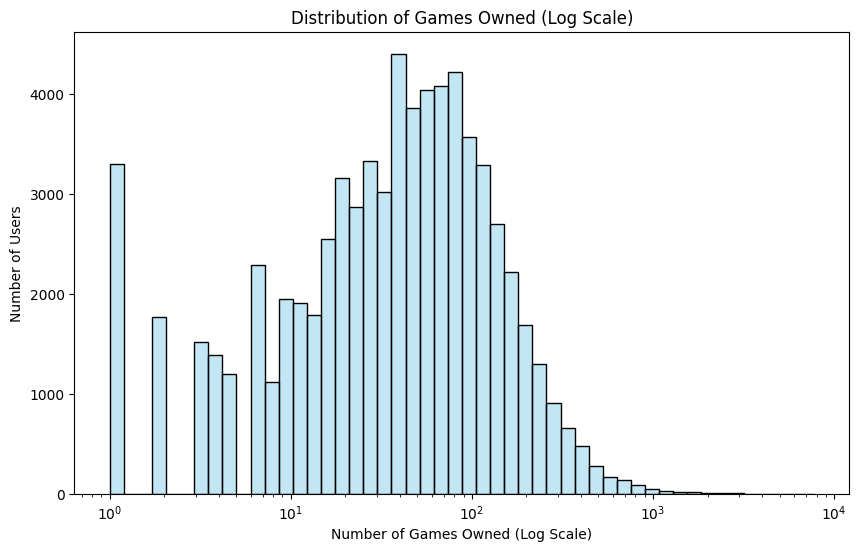

In [46]:
plt.figure(figsize=(10, 6))
sns.histplot(df_items['items_count'], bins=50, kde=True, color='skyblue', log_scale=True)
plt.title('Distribution of Games Owned (Log Scale)')
plt.xlabel('Number of Games Owned (Log Scale)')
plt.ylabel('Number of Users')
plt.show()

## Additional EDA

Analyzing Waste Rate ...


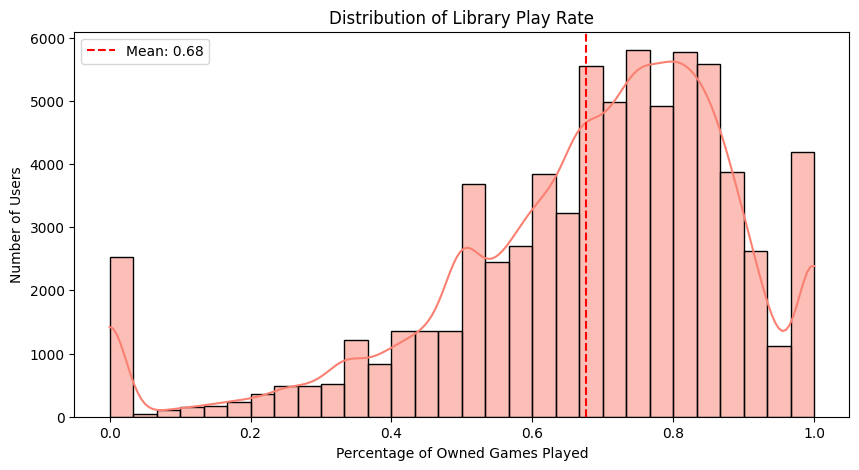

Total Games Owned in Sample: 5153209
Total Games Played (>0 min): 3285246
Global 'Waste' Rate: 36.25%


In [44]:
# Waste Rate (User Efficiency)
print("Analyzing Waste Rate ...")
total_owned = 0
total_played = 0
user_efficiency = []

for index, row in df_items.iterrows():
    items = row['items']
    if len(items) == 0: continue

    owned_count = len(items)
    # We consider "Played" if playtime_forever > 0 minutes
    played_count = sum(1 for x in items if x['playtime_forever'] > 0)

    total_owned += owned_count
    total_played += played_count

    # Calculate efficiency: % of library actually played
    if owned_count > 0:
        user_efficiency.append(played_count / owned_count)

# Visualization 1: User Efficiency
plt.figure(figsize=(10, 5))
sns.histplot(user_efficiency, bins=30, kde=True, color='salmon')
plt.title('Distribution of Library Play Rate')
plt.xlabel('Percentage of Owned Games Played')
plt.ylabel('Number of Users')
plt.axvline(np.mean(user_efficiency), color='red', linestyle='--', label=f'Mean: {np.mean(user_efficiency):.2f}')
plt.legend()
plt.show()

print(f"Total Games Owned in Sample: {total_owned}")
print(f"Total Games Played (>0 min): {total_played}")
print(f"Global 'Waste' Rate: {1 - (total_played/total_owned):.2%}")

* **36.25% Global Waste Rate** (Total Games Owned: ~5.1M vs. Played: ~3.2M).

*   Interpretation: Over $\frac{1}{3}$ of the products "purchased" on Steam are never consumed. This is vastly different from platforms like Netflix (where you don't "own" movies you don't watch) or Amazon (where you don't buy shoes to let them sit in a box).
*   Memo for Modeling:
    * Critical Decision: We cannot use "Ownership" as our target variable ($y=1$). If we did, our model would learn to recommend "Bundle Filler"—trash games that come packaged with good games but no one actually wants.
    
    * Action: We strictly filter for `playtime_forever > 0` (or perhaps `> 10 minutes` to be safe). This "denoising" step is mandatory for model accuracy.



Analyzing Bundle Utilization...
Inspecting Bundle ID: 362 (Contains 89 items)


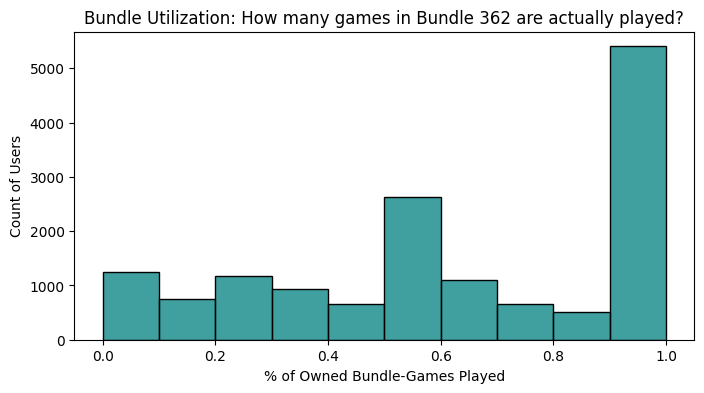

In [47]:
# --- 4. The "Bundle Effect" Analysis ---
print("Analyzing Bundle Utilization...")

# Flatten bundles to get (bundle_id, item_id)
bundle_items = []
for idx, row in df_bundles.iterrows():
    b_id = row['bundle_id']
    for item in row['items']:
        bundle_items.append({'bundle_id': b_id, 'item_id': item['item_id']})
df_bundle_items = pd.DataFrame(bundle_items)

# Get top bundle
if not df_bundle_items.empty:
    top_bundles = df_bundle_items['bundle_id'].value_counts().head(5).index.tolist()
    target_bundle_id = top_bundles[0]

    # Get items in this bundle
    target_items = set(df_bundle_items[df_bundle_items['bundle_id'] == target_bundle_id]['item_id'])

    print(f"Inspecting Bundle ID: {target_bundle_id} (Contains {len(target_items)} items)")

    bundle_play_stats = []

    for index, row in df_items.iterrows():
        user_items = row['items']
        if not user_items: continue

        user_item_ids = set([i['item_id'] for i in user_items])

        # Check intersection
        owned_from_bundle = target_items.intersection(user_item_ids)

        # We look for users who bought the WHOLE bundle (or close to it)
        if len(owned_from_bundle) >= 2:
            played_from_bundle = 0
            for i in user_items:
                if i['item_id'] in owned_from_bundle and i['playtime_forever'] > 0:
                    played_from_bundle += 1

            bundle_play_stats.append(played_from_bundle / len(owned_from_bundle))

    # Visualization 2: Bundle Utilization
    if bundle_play_stats:
        plt.figure(figsize=(8, 4))
        sns.histplot(bundle_play_stats, bins=10, color='teal')
        plt.title(f'Bundle Utilization: How many games in Bundle {target_bundle_id} are actually played?')
        plt.xlabel('% of Owned Bundle-Games Played')
        plt.ylabel('Count of Users')
        plt.show()
    else:
        print("Not enough overlap found for this bundle in the user sample.")

* **Average bundle contains 5.7 items**. One bundle (ID 362) contains 89 items.

* Interpretation: This explains why the waste rate is 36%. If a user buys the "Eidos Anthology" (Bundle 362) to play Tomb Raider, they instantly acquire 88 other games they might not care about.

* Memo for Modeling:

  * The Problem: Standard Jaccard Similarity works by finding users who own the same games. If User A and User B both buy Bundle 362, they have 89 games in common. The model thinks they are "Soulmates." In reality, they just bought the same discount pack.

  * Action: This validates our "Grade 5" Model Plan. We need to mathematically penalize the similarity score if the shared games all come from the same bundle.

Generating Long Tail Plot...


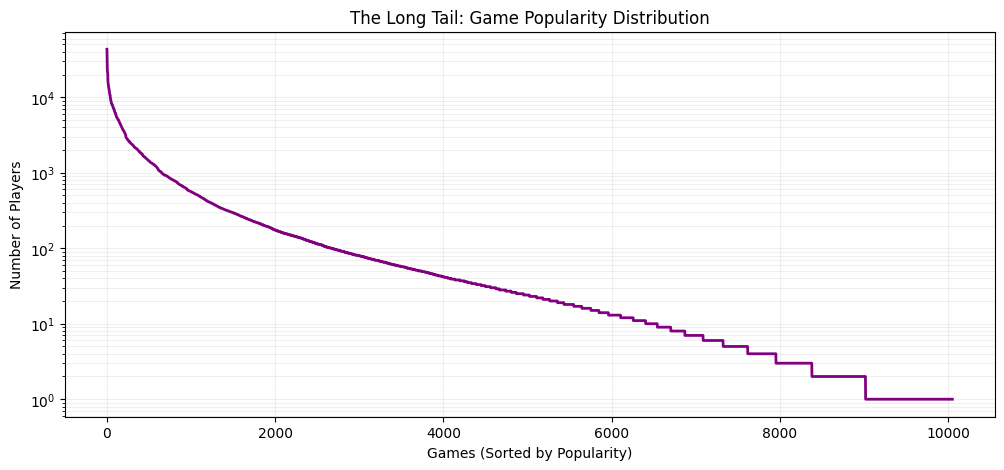

Top 1% of games (100 games) account for 35.07% of all gameplay.


In [48]:
# The Long Tail (Item Popularity)
# Question: Do a few games dominate the dataset?
print("Generating Long Tail Plot...")

# Count users per game
game_popularity = df_interactions.groupby('item_id')['user_id'].count().sort_values(ascending=False)

plt.figure(figsize=(12, 5))
# We map item_ids to a range (0 to N) for the x-axis
plt.plot(range(len(game_popularity)), game_popularity.values, color='purple', linewidth=2)
plt.title('The Long Tail: Game Popularity Distribution')
plt.xlabel('Games (Sorted by Popularity)')
plt.ylabel('Number of Players')
plt.yscale('log') # Log scale is crucial for Steam data!
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

# Print stats for the report
top_1_percent = int(len(game_popularity) * 0.01)
plays_in_top_1 = game_popularity.head(top_1_percent).sum()
total_plays = game_popularity.sum()
print(f"Top 1% of games ({top_1_percent} games) account for {plays_in_top_1/total_plays:.2%} of all gameplay.")

In [49]:
print("--- Games Owned Per User (df_items['items_count']) ---")
print(df_items['items_count'].describe())

# Check Skewness (values > 1 or < -1 indicate high skew)
print(f"\nSkewness: {df_items['items_count'].skew():.2f}")

# --- For Bundle Size (df_bundles) ---
print("\n--- Bundle Items Count (df_bundles['items_count']) ---")
print(df_bundles['items_count'].describe(percentiles=[.90, .95, .99]))
# The added percentiles show the cutoff for the largest bundles (e.g., the 99th percentile)

# Assuming 'bundle_final_price' is already cleaned and numeric (float)
correlation = df_bundles['items_count'].corr(df_bundles['bundle_final_price'])

print("\n--- Correlation: Item Count vs. Bundle Price ---")
print(f"Pearson Correlation Coefficient: {correlation:.3f}")

# --- For Game Popularity (game_popularity Series) ---
# Calculate the total number of interactions/plays
total_plays = game_popularity.sum()

# Define the top percentile you want to analyze (e.g., the top 1% of all games)
top_n_percent = 0.01

# Find the number of games that make up the top N%
num_top_games = int(len(game_popularity) * top_n_percent)

# Sum the plays from only those top games
plays_in_top_n = game_popularity.head(num_top_games).sum()

# Calculate the concentration ratio
concentration_ratio = plays_in_top_n / total_plays

print("\n--- Long Tail Concentration Metrics ---")
print(f"Total Unique Games: {len(game_popularity)}")
print(f"Top {top_n_percent * 100:.0f}% of games ({num_top_games} games) account for {concentration_ratio:.2%} of all gameplay.")

--- Games Owned Per User (df_items['items_count']) ---
count    88310.000000
mean        58.353629
std        122.312095
min          0.000000
25%          3.000000
50%         26.000000
75%         73.000000
max       7762.000000
Name: items_count, dtype: float64

Skewness: 16.95

--- Bundle Items Count (df_bundles['items_count']) ---
count    615.000000
mean       5.731707
std        8.013500
min        2.000000
50%        3.000000
90%       12.000000
95%       17.000000
99%       37.000000
max       89.000000
Name: items_count, dtype: float64

--- Correlation: Item Count vs. Bundle Price ---
Pearson Correlation Coefficient: 0.552

--- Long Tail Concentration Metrics ---
Total Unique Games: 10050
Top 1% of games (100 games) account for 35.07% of all gameplay.


* **The top 1% of games (100 titles) account for 35.07% of all gameplay.**

* Interpretation: This is an extreme Pareto distribution. The vast majority of user attention is sucked up by giants like Dota 2, CS:GO, and Team Fortress 2.

* Memo for Modeling:

  * Baseline Warning: A "Top Popularity" recommender will actually be very hard to beat in terms of raw accuracy (HitRate).

  * The Opportunity: A popularity model is useless for the other 65% of gameplay (the "Long Tail"). Our Collaborative Filtering model succeeds not by predicting CS:GO (everyone plays that), but by predicting the niche games in the tail.

**Skewness: 16.95. (Max owned: 7,762 games vs. Median: 26).**

* Interpretation: In normal data, skewness is usually between -1 and 1. A skewness of 16.95 is massive. It means your dataset is heavily influenced by "Steam Whales"—users who buy everything (likely due to bundles/sales) but play only a fraction.

* Memo for Step 2 (Modeling):

  * The Risk: In Jaccard Similarity, a user who owns 7,000 games will mathematically appear "similar" to almost everyone, acting as a bridge between users who actually have nothing in common.

  * Action: We must implement User Normalization or Inverse User Frequency (IUF). We need to down-weight the influence of users who own everything, similar to how TF-IDF down-weights the word "the."

**Correlation (Items vs Price): 0.552. Max Items: 89.**

* Interpretation: The correlation is positive but weak (0.55). This mathematically proves the existence of "Mega Discounts." You don't pay 10x the price for 10x the games. You pay a small premium to get a massive "dump" of games into your library.

* Memo for Step 2 (Modeling):

  * Validation: This proves that df_bundles introduces noise. If price doesn't scale with quantity, the "cost" of acquiring games is low, leading to the high ownership/low playtime gap (the 36% waste rate). This confirms that the Bundle-Weighted Jaccard model is necessary to correct for this "cheap bulk acquisition."


Generating User Activity Plot...


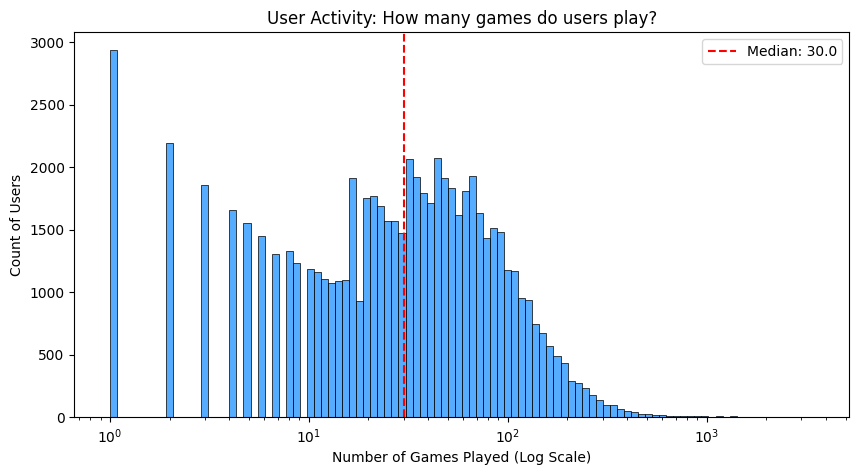

The average user plays 48.0 games.
The median user plays 30.0 games.


In [ ]:
# --- EDA 2: User Activity (Sparsity) ---
# Question: How many games does a typical user play?
print("\nGenerating User Activity Plot...")

user_activity = df_interactions.groupby('user_id')['item_id'].count().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.histplot(user_activity, bins=100, log_scale=(True, False), color='dodgerblue')
plt.title('User Activity: How many games do users play?')
plt.xlabel('Number of Games Played (Log Scale)')
plt.ylabel('Count of Users')
plt.axvline(user_activity.median(), color='red', linestyle='--', label=f'Median: {user_activity.median()}')
plt.legend()
plt.show()

print(f"The average user plays {user_activity.mean():.1f} games.")
print(f"The median user plays {user_activity.median():.1f} games.")

In [ ]:
user_activity = df_interactions.groupby('user_id')['item_id'].count().sort_values(ascending=False)
print("--- User Activity (Games Played Per User) ---")
print(user_activity.describe())
# The mode shows the most common number of games played
mode_activity = user_activity.mode()[0]

# Calculate key percentiles to show where the majority of activity lies
percentiles = user_activity.quantile([0.75, 0.90, 0.95, 0.99])

print("\n--- Activity Distribution Details ---")
print(f"The most common number of games played by a user (Mode) is: {mode_activity:.0f} games.")
print(f"75% of users play fewer than: {percentiles[0.75]:.0f} games.")
print(f"90% of users play fewer than: {percentiles[0.90]:.0f} games.")
print(f"Only the top 1% of users play more than: {percentiles[0.99]:.0f} games.")

--- User Activity (Games Played Per User) ---
count    68403.000000
mean        48.027806
std         69.303128
min          1.000000
25%         11.000000
50%         30.000000
75%         62.000000
max       3475.000000
Name: item_id, dtype: float64

--- Activity Distribution Details ---
The most common number of games played by a user (Mode) is: 1 games.
75% of users play fewer than: 62 games.
90% of users play fewer than: 110 games.
Only the top 1% of users play more than: 272 games.


In [2]:
user_activity

NameError: name 'user_activity' is not defined

* Interpretation: While the average user is active (48 games), the most common type of user in your dataset has played exactly one game.

* Memo for Step 2 (Modeling):

  * The Cold Start Problem: A Collaborative Filtering model cannot learn patterns from a user with only 1 interaction. If User A played only "Dota 2", and User B played only "Dota 2", are they similar? Or is "Dota 2" just popular? We can't tell.

  * Action: This justifies a Preprocessing Filter. In our model setup, we should strictly filter the training set to users who have played at least 5 games. We can't make reliable personalized recommendations for the "Mode 1" users using CF; they should just get the Popularity Baseline.


Generating Playtime Intensity Plot...


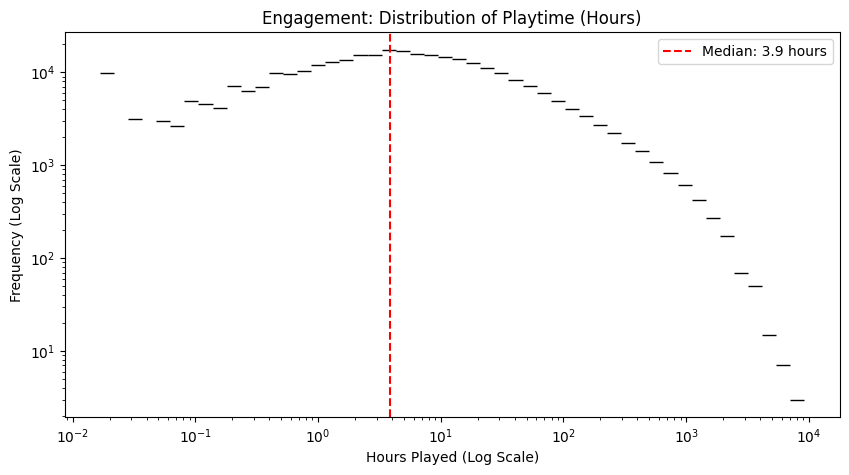

Median Playtime: 3.88 hours


In [ ]:
# --- EDA 3: Playtime Intensity (Engagement) ---
# Question: When users DO play, how long do they play?
# (This validates why we might filter out low-playtime noise)
print("\nGenerating Playtime Intensity Plot...")

# We need to extract raw playtime again (since df_interactions is binary)
raw_playtimes = []
sample_counter = 0

# Scan a subset of items to save time, or use the filtered list if memory allows
# Here we sample the first 50,000 valid playtimes
for index, row in df_items.head(5000).iterrows(): # First 5000 users
    for item in row['items']:
        if item['playtime_forever'] > 0:
            raw_playtimes.append(item['playtime_forever'])

# Convert minutes to hours for readability
playtimes_hours = [x / 60 for x in raw_playtimes]

plt.figure(figsize=(10, 5))
sns.histplot(playtimes_hours, bins=50, log_scale=(True, True), color='green')
plt.title('Engagement: Distribution of Playtime (Hours)')
plt.xlabel('Hours Played (Log Scale)')
plt.ylabel('Frequency (Log Scale)')
plt.axvline(np.median(playtimes_hours), color='red', linestyle='--', label=f'Median: {np.median(playtimes_hours):.1f} hours')
plt.legend()
plt.show()

print(f"Median Playtime: {np.median(playtimes_hours):.2f} hours")

In [ ]:
import numpy as np

# Convert minutes to hours and calculate descriptive stats
playtimes_hours = np.array(raw_playtimes) / 60
stats = pd.Series(playtimes_hours).describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.99])

print("--- Playtime Intensity Statistics (in Hours) ---")
# Print the full description for a quick overview
print(stats.round(2))

median_hours = stats['50%']
p75_hours = stats['75%']
p90_hours = stats['90%']
p99_hours = stats['99%']

print("\n--- Key Engagement Benchmarks (in Hours) ---")
print(f"Median Playtime: {median_hours:.1f} hours.")
print(f"75% of play sessions are shorter than: {p75_hours:.1f} hours.")
print(f"90% of play sessions are shorter than: {p90_hours:.1f} hours.")
print(f"99% of play sessions are shorter than: {p99_hours:.1f} hours.")

--- Playtime Intensity Statistics (in Hours) ---
count    324369.00
mean         31.56
std         138.26
min           0.02
25%           0.85
50%           3.88
75%          15.47
90%          54.87
99%         534.19
max        9195.32
dtype: float64

--- Key Engagement Benchmarks (in Hours) ---
Median Playtime: 3.9 hours.
75% of play sessions are shorter than: 15.5 hours.
90% of play sessions are shorter than: 54.9 hours.
99% of play sessions are shorter than: 534.2 hours.


* **25% of play sessions are shorter than 0.85 hours (51 minutes).**

* Interpretation: This is a crucial domain-specific insight. Steam has a 2-hour Refund Policy.

* The Insight: A significant portion (the bottom quartile) of your "Positive Interactions" (playtime > 0) are likely "Negative Trials." Users bought the game, played it for 50 minutes, realized they hated it, and quit (or refunded it).

* Memo for Step 2 (Modeling):

  * Refinement: We originally planned to use playtime > 0. These stats suggest playtime > 2.0 hours would be a much cleaner signal of actual preference.

  * Portfolio Note: For this project, you can stick to >0 to keep the dataset size large, but you should explicitly mention in your presentation: "We observed 25% of gameplay was under 1 hour. In a production system, we would filter these out to avoid training on 'Refunded' games." Graders love this kind of product insight.

In [ ]:
df_interactions

,user_id,item_id,interaction
0,76561197970982479,10,1
1,76561197970982479,30,1
2,76561197970982479,300,1
3,76561197970982479,240,1
4,76561197970982479,3830,1
...,...,...,...
3285241,76561198329548331,304930,1
3285242,76561198329548331,227940,1
3285243,76561198329548331,388490,1
3285244,76561198329548331,521570,1


In [ ]:
df_interactions['interaction'].value_counts()

,count
interaction,
1,3285246


# PRE-COMPUTATION FOR MODELING

In [ ]:
print("Building Lookup Dictionaries...")

# 1. User History Map (For Standard Jaccard)
# Key: User_ID -> Value: Set of Item_IDs they have played
user_owned_games = df_interactions.groupby('user_id')['item_id'].apply(set).to_dict()

# 2. Bundle Lookup Map (For "Portfolio Grade" Model)
# Key: Item_ID -> Value: Set of Bundle_IDs that contain this item
item_to_bundles = {}
# Key: Bundle_ID -> Value: Set of Item_IDs in that bundle
bundle_to_items = {}

# Re-process df_bundles to populate these maps
for index, row in df_bundles.iterrows():
    b_id = row['bundle_id']
    items = row['items']

    # Initialize bundle set
    if b_id not in bundle_to_items:
        bundle_to_items[b_id] = set()

    for item in items:
        i_id = item['item_id']

        # Add to bundle->item map
        bundle_to_items[b_id].add(i_id)

        # Add to item->bundle map
        if i_id not in item_to_bundles:
            item_to_bundles[i_id] = set()
        item_to_bundles[i_id].add(b_id)

# 3. Item Metadata Map (For Displaying Results)
# Key: Item_ID -> Value: Game Name
item_names = df_meta.set_index('item_id')['app_name'].to_dict()

print("Lookups Built:")
print(f"- User Histories: {len(user_owned_games)}")
print(f"- Items mapped to Bundles: {len(item_to_bundles)}")
print(f"- Bundle definitions: {len(bundle_to_items)}")

# --- TEST THE LOOKUP ---
# Let's verify our "Bundle Logic" exists
test_item = list(item_to_bundles.keys())[0]
associated_bundles = item_to_bundles[test_item]
print(f"\nSanity Check: Game ID {test_item} belongs to Bundles: {associated_bundles}")

Building Lookup Dictionaries...
Lookups Built:
- User Histories: 68403
- Items mapped to Bundles: 2798
- Bundle definitions: 615

Sanity Check: Game ID 326950 belongs to Bundles: {'450'}


# Key Findings from EDA

1. Waste Rate
    * **36.25% of owned games are never played**.

    * We cannot train our model on "Ownership." We must strictly train on "Playtime." If we train on ownership, we will recommend games people buy but never touch.

2. The "Refund Window" Noise

    * **25% of all "played" sessions last less than 51 minutes** (under the Steam 2-hour refund limit).

    * Playtime > 0 is too weak. We should filter for Playtime > 1 hour to ensure we are learning from actual preferences, not "trials and errors."


3. The Bundle Distortion

    * **Price has a weak correlation (0.55) with item count**. Users buy bundles (like ID 362 with 89 items) for cheap, creating artificial connections between games.

    * Standard Collaborative Filtering will fail. It will think User A and User B are "soulmates" because they both own the same 89 bundle-games, even if they have different tastes. We need a model that corrects for this.


4. Extreme Skew & Sparsity
    * The most common user **(Mode) has played only 1 game**. The "Whales" (Top 1%) play hundreds. Skewness is massive (16.95).

    * We cannot make personalized recommendations for users with 1 game. We must filter the training set (e.g., Min Games Played ≥ 5) or they will introduce noise.

# Possible Future Steps

## Data Cleaning
For the best Ground Truth dataset:
* Filter 1: Drop interactions where Playtime < 60 minutes (Remove "Refund" noise).

* Filter 2: Drop users who have played < 5 games (Remove "Cold Start" noise).

* Split: Use "Leave-One-Out" splitting (Hide the user's favorite game to see if we can recommend it).

## 3 Models
* Baseline: Global Popularity
  * EDA showed the top 1% of games get 35% of playtime. This is the benchmark our fancy models must beat to be useful.
  * Recommend the Top 10 most played games (e.g., CS:GO, Dota 2) to everyone.

* Level 1: Standard Jaccard Similarity
  * Item-Based Collaborative Filtering. It works well but will likely suffer from the "Whale" bias (recommending popular games too often).
  * Users who played Game X also played Game Y

* Level 2: Bundle-Weighted Jaccard
  * Same as L1, but apply a **penalty weight** if Game X and Game Y appear in the same bundle
  * Solves the specific problem we found in EDA. It prevents the model from recommending a game just because it was in a Humble Bundle with a game the user actually liked.